### Load excel data into df

In [1]:
import pandas as pd

# Load the Excel file
df_off = pd.read_excel('/Users/gab/Desktop/DA_FIFA/FIFA_Data_Analytics/Data.xlsx', sheet_name='OFF')
df_def = pd.read_excel('/Users/gab/Desktop/DA_FIFA/FIFA_Data_Analytics/Data.xlsx', sheet_name='DEF')
df_mid = pd.read_excel('/Users/gab/Desktop/DA_FIFA/FIFA_Data_Analytics/Data.xlsx', sheet_name='MID')

# drop the string columns and ignore the errors
def clean_data(df):
    df = df.drop(columns=['Name', 'Position'])
    df = df.apply(pd.to_numeric, errors ='coerce').dropna()
    return df

df_off = clean_data(df_off)
df_mid = clean_data(df_mid)
df_def = clean_data(df_def)

### Visualizing the relationship

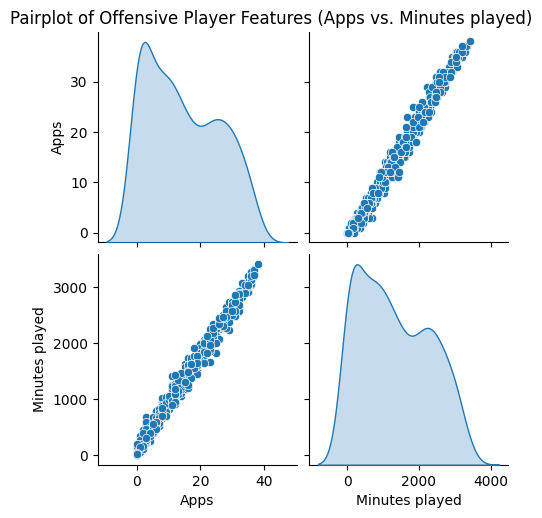

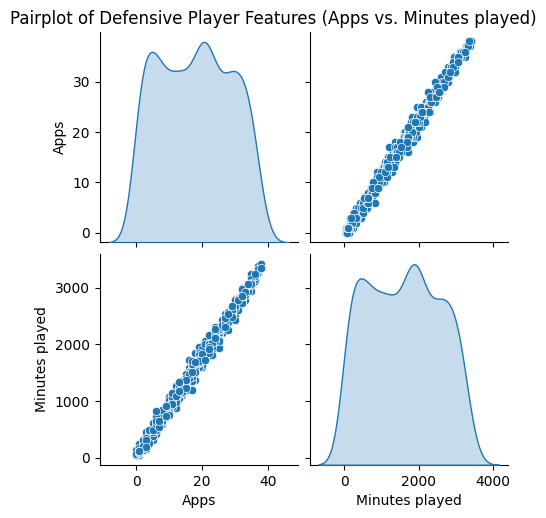

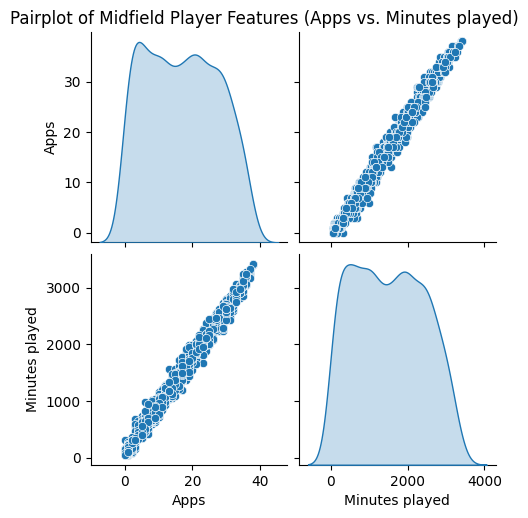

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def correlation_matrix(df, position, ft1, ft2):
    sns.pairplot(df[[ft1, ft2]], diag_kind='kde')
    plt.suptitle(f'Pairplot of {position} Player Features ({ft1} vs. {ft2})', y=1.02)
    plt.show()

correlation_matrix(df_off, 'Offensive', 'Apps', 'Minutes played')
correlation_matrix(df_def, 'Defensive', 'Apps', 'Minutes played')
correlation_matrix(df_mid, 'Midfield', 'Apps', 'Minutes played')

### Select best features

In [13]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.metrics import mean_squared_error, r2_score

def select_randomForest(X, y, n_features):
    model_rf = RandomForestRegressor(random_state=42)
    model_rf.fit(X, y)
    importances = model_rf.feature_importances_
    feature_importances = pd.Series(importances, index=X.columns) #!?
    selector = SelectFromModel(model_rf, threshold=-np.inf, max_features=n_features, prefit=True)
    important_features = X.columns[selector.get_support()]
    return important_features, feature_importances

def plot_feature_importances(importances, features, position, model_name, n_features):
    feature_importances = pd.Series(importances, index=features)
    feature_importances.nlargest(n_features).sort_values(ascending=True).plot(kind='barh')
    plt.title(f"Top {n_features} Features for {position} Players ({model_name})")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.show()

def test_model_performance(X, y, position, model, model_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Performance for {position} Players ({model_name}):")
    print(f"MSE: {mse}, R-squared: {r2}")

def feature_selection_pipeline(df, position, feature_selector, model_name, amount_of_features):
    X = df.drop(columns=['Rating'])
    y = df['Rating']

    selected_features, importances = feature_selector(X, y, amount_of_features)
    plot_feature_importances(importances, X.columns, position, model_name, amount_of_features)
    
    return df[selected_features.tolist() + ['Rating']]

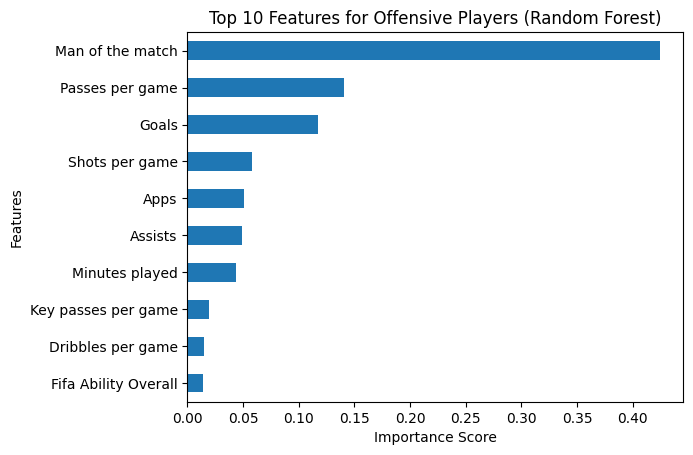

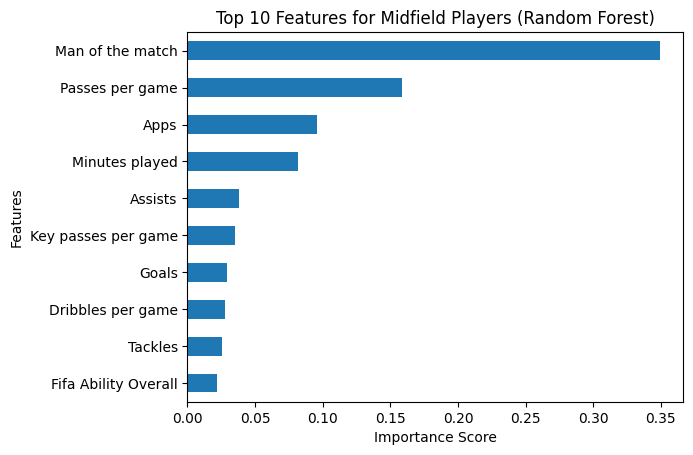

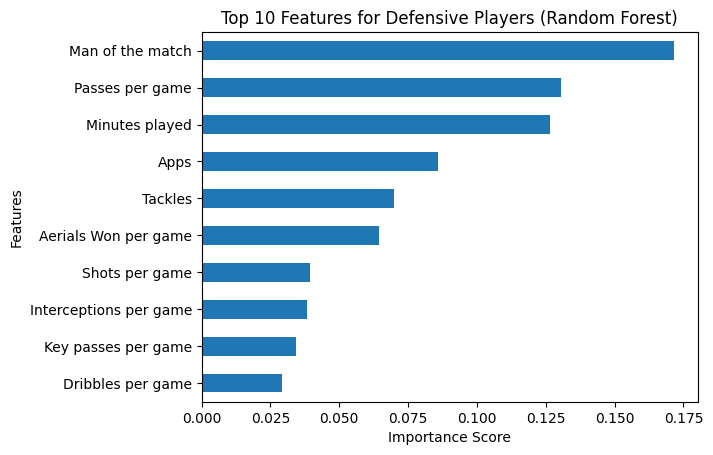

In [15]:
df_off_rf = feature_selection_pipeline(df_off, 'Offensive', select_randomForest, 'Random Forest', 10)
df_mid_rf = feature_selection_pipeline(df_mid, 'Midfield', select_randomForest, 'Random Forest', 10)
df_def_rf = feature_selection_pipeline(df_def, 'Defensive', select_randomForest, 'Random Forest', 10)

In [16]:
# Model performance testing
print("\nModel Performance Testing\n")

# Offensive players
print("\nOffensive Players\n")
test_model_performance(df_off_rf.drop(columns=['Rating']), df_off_rf['Rating'], 'Offensive', RandomForestRegressor(random_state=42), 'Random Forest')

# Midfield players
print("\nMidfield Players\n")
test_model_performance(df_mid_rf.drop(columns=['Rating']), df_mid_rf['Rating'], 'Midfield', RandomForestRegressor(random_state=42), 'Random Forest')

# Defensive players
print("\nDefensive Players\n")
test_model_performance(df_def_rf.drop(columns=['Rating']), df_def_rf['Rating'], 'Defensive', RandomForestRegressor(random_state=42), 'Random Forest')



Model Performance Testing


Offensive Players

Performance for Offensive Players (Random Forest):
MSE: 0.01902303812500001, R-squared: 0.8838882868104678

Midfield Players

Performance for Midfield Players (Random Forest):
MSE: 0.021086135480427128, R-squared: 0.8068313754292558

Defensive Players

Performance for Defensive Players (Random Forest):
MSE: 0.02227557467032978, R-squared: 0.6723033913840986
